In [1]:
# Importing necessary libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from collections import Counter

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

In [3]:
# Importing performance metrics
from sklearn import preprocessing,metrics

from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)


In [4]:
# Hyperparameter Tuning
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)


In [5]:
# Importing performance metrics
from sklearn import preprocessing,metrics
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.metrics import  precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,auc, roc_curve, plot_confusion_matrix


In [7]:
data = pd.read_csv('/content/dataset_small.csv')
df = data.copy()


In [8]:
df.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url',
       ...
       'qty_ip_resolved', 'qty_nameservers', 'qty_mx_servers', 'ttl_hostname',
       'tls_ssl_certificate', 'qty_redirects', 'url_google_index',
       'domain_google_index', 'url_shortened', 'phishing'],
      dtype='object', length=112)

In [9]:
df.isnull().sum() # There are no missing values present in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


In [10]:

# Finding number of levels in each variable
unique = df.nunique().sort_values(ascending = False)
# The variables which has only one unique value have same fixed value for all samples so such variables cannot be considered as variable 


In [11]:

# Removing variables which has same value for all samples
# Extracting variable names with only 1 uniques level
noVar = unique[unique == 1].index

df.drop(columns = noVar, axis = 1, inplace = True)

In [12]:

# Removed duplicates
df.drop_duplicates(keep = 'first', inplace = True)


In [13]:

# Function for replacing outliers with IQR method
# Parameters: var is column whose outliers needs to be replaced 
# Returns: 25th and 75th quantile of the variable in variable lower and upper
def fun_iqr(var):
    # Calculating 25th and 75th quartile
    q25, q75 = var.quantile(0.25), var.quantile(0.75)

    # calculating interquartile range
    iqr = q75-q25

    # Calculating upper and lower whiskers of boxplot
    lower, upper = q25 - 1.5*iqr, q75 + 1.5*iqr
    return lower, upper



In [14]:

# outliers function replaces the outlier i.e. values below 25th quantile and above 75th quantile, with median of the variable
# Parameters: Dataframe df, list of all columns in df dataframe
# Returns: Dataframe df without outliers
def outliers(df,list):
    for i in range(len(list)):
        # IQR method for replacing outliers
        lower, upper = fun_iqr(df[list[i]])
        
        # Replacing the outliers with median( Median is considered because it is not affected by outliers) to prevent the loss of data
        df[list[i]] = np.where((df[list[i]] < lower) | (df[list[i]] > upper), df[list[i]].median(), df[list[i]])

        #sns.boxplot(y=df[list[i]])
        #plt.show()


ls = df.columns
outliers(df, ls)

In [15]:

# Function for classification report and confusion matrix
# Parameters: test data actual labels in y_test and predicted labels from model in y_pred_test
# Returns: Prints classification report and plot of confusion matrix
# Function for classification report and confusion matrix
def evaluate_classification_model(y_test, y_pred_test):
    
    target_names = ['Non-phishing', 'Phishing']

    print(classification_report(y_test, y_pred_test, target_names=target_names))


    conf_matrix = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(data=conf_matrix, annot=True, fmt='g', xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xtickslabels(rotation=90)
    plt.ytickslabels(rotation=90)
    plt.yticks(target_names)
    plt.show()


In [16]:

## Define function for obtaining predicted class and predicted probabilities for the classes when model is applied on test data
def fit_n_pred(model, X_tr, y_tr, X_te):
    
    """Takes in Classifier, training data (X,y), and test data(X). Will output 
    predictions based upon both the training and test data using the sklearn
    .predict method. MUST unpack into two variables (train, test)."""
    
    ## Fitting classifier to training data
    model.fit(X_tr, y_tr)

    ## Generate predictions for training + test data
    y_preds = model.predict(X_te)
    y_preds_prob = model.predict_proba(X_te)[:,1]
    
    ## Optional display check
    #display(model)
    #print(model.best_params_)
    
    return y_preds, y_preds_prob



In [17]:

#plot_curve(y_test, y_preds_prob, 'Random Forest with Important Features')
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = metrics.roc_curve(truth,pred)       # Returns fpr, tpr and thresholds
    roc_auc = metrics.auc(fpr, tpr)                            # Returns area under the curve 
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right", fontsize=10)
    
    
def feature_importance(model, X, label):
# Set importance features
    importance = model.feature_importances_

    d = {'Features':X.columns, 'Feature Importance': model.feature_importances_}
    dataframe = pd.DataFrame(d)

# Display the top 30 feature based on feature importance
    topFI = dataframe.sort_values(by='Feature Importance', ascending=False).head(30)

# Plot feature importance
    plt.rcParams["figure.figsize"] = (10, 10)

    y_axis = topFI['Features']
    x_axis = topFI['Feature Importance']
    plt.barh(y_axis, x_axis)
    plt.title('Plot FI: ' + label)
    plt.ylabel('Features')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    plt.savefig('E:/Anukriti/Avrutti Research/Task 10-Misbehaviour Dtetection in VANET_ML/Models data/FI_RF_1l_new.png')
    plt.show()
    
def save_model(model, filename):
    import pickle
    from os import path
    pkl_filename = "/content/dataset/savedFiles" + "/" + filename + ".pkl"
    if (not path.isfile(pkl_filename)):
  # saving the trained model to disk 
      with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)
      print("Saved model to disk")
    else:
      print("Previous Model exists on the disk! Please Remove")



In [18]:

# As dataset has 58,645 samples and 99 variables it is not possible to handle outliers and check normal distribution for each variable.
# Therefore we will perform feature selection using those algorithms which are robust to outliers and distribution of the variable. 
# Feature Importance: Choice of ML algorithms:
# 1. Random Forest
# 2. XG Boost
# 3. PCA

# Feature Importance: Random Forest

# Creating train test data (retaining original dataframe in df)
y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)




In [19]:

# Checking the balance of dataset
from collections import Counter
Counter(df['phishing']) # Data is nearly balanced
phishingClassRatio = df[df['phishing'] == 1].shape[0]/df.shape[0]*100
print("Percentage of phishing data in dataset: ", round(phishingClassRatio,2))



Percentage of phishing data in dataset:  53.13


              precision    recall  f1-score   support

Non-phishing       0.95      0.90      0.93      8865
    Phishing       0.92      0.96      0.94     10079

    accuracy                           0.93     18944
   macro avg       0.93      0.93      0.93     18944
weighted avg       0.93      0.93      0.93     18944



AttributeError: ignored

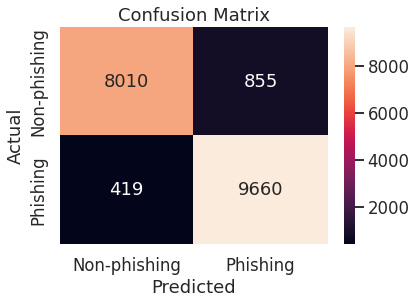

In [20]:

# 1. Random Forest Hyperparameter Tuning
params = {'n_estimators': [50, 100, 200],
 'max_depth': [4, 6, 10, 12],
 'criterion': ['gini', 'entropy'],
 'random_state': [13]}


imba_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=13))

# Attaching name of classifier with name of each parameter for passing to Randomized Search CV
new_params = {'randomforestclassifier__' + key: params[key] for key in params} # Passing the parameters

rs_rf = RandomizedSearchCV(imba_pipeline, new_params, cv=5, scoring = 'accuracy')

y_pred, y_pred_prob = fit_n_pred(rs_rf, X_train, y_train, X_test)
rs_rf.best_params_

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'Random Forest')

FileNotFoundError: ignored

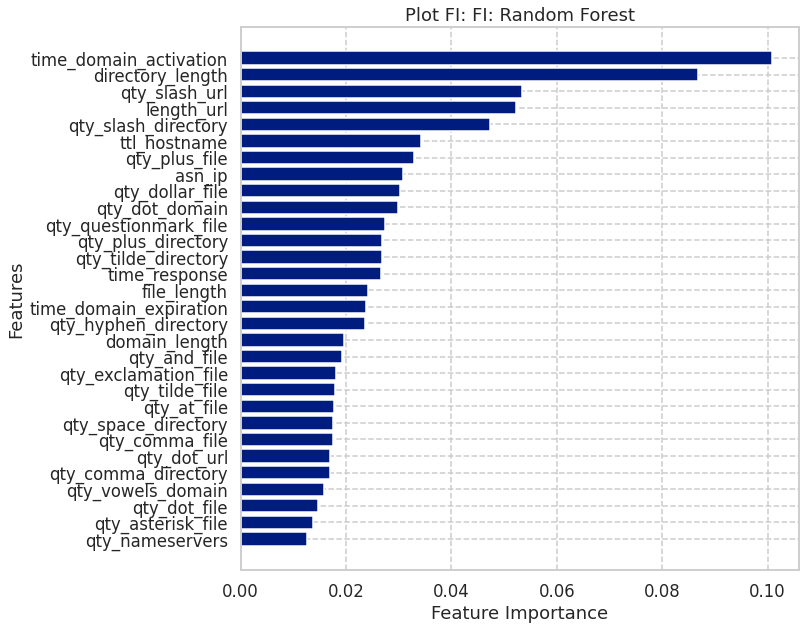

In [21]:

# Randomized Search object has no attribute feature_importance_ so creating new RF object with best parameters
# 2.  Random Forest Model with Best parameters

# Preparing data
y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)
col = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)


rf = RandomForestClassifier(n_estimators = 50, max_depth = 12, random_state = 13, criterion = 'entropy')
rf.fit(X_train,y_train)
feature_importance(rf, X, 'FI: Random Forest')


# Fit model using each importance as a threshold
from sklearn.feature_selection import SelectFromModel

thresholds = sorted(rf.feature_importances_, reverse = True)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(rf, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier(n_estimators = 50, max_depth = 12, random_state = 13, criterion = 'entropy')
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))


# Selecting threshold=0.009 with n=37 achieving an accuracy of 94%
# Random Forest classifier with important features
importance = rf.feature_importances_
d = {'Features':X.columns, 'Feature Importance': rf.feature_importances_}
dataframe = pd.DataFrame(d)

# Display the top 37 feature based on feature importance. The highest accuracy of 94% is achieved at n=37 and FI score = 0.09. Therefore selecting top 37 features
topFI = dataframe.sort_values(by='Feature Importance', ascending=False).head(42)

# Selecting the columns with feature importance score of more than 0.061 because accuracy is increased and number of features is also nominal otherwise if accuracy of 77.35% is chosen then n=3 is very less for model to identify pattern
selCols = topFI.loc[topFI['Feature Importance'] >= 0.004]
selCols = selCols['Features'].tolist()


X = df[selCols]
y = df['phishing']
col = X.columns


X.columns

sc = StandardScaler()
X = sc.fit_transform(X)
X = pd.DataFrame(X, columns = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)

rf = RandomForestClassifier(n_estimators = 50, max_depth = 12, random_state = 13, criterion = 'entropy')
y_pred, y_pred_prob = fit_n_pred(rs_rf, X_train, y_train, X_test)

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'Random Forest')

save_model(rf, 'model_RfFi2')


# Pairplot for reduced number of features (n=41)
# Pairplot to observe the pattern of feature set: whether linearly or non-linearly separable w.r.t. target variable
columns = list(X.columns)
columns.append('phishing')
dataPair = df[columns]
sns.pairplot(dataPair, hue = 'phishing', palette = 'hls')
plt.show()


In [22]:
"""
# 3. Random Forest Model with important Features and Best parameters
# Extracting important features in X
X = df[['time_domain_activation','directory_length','length_url', 'qty_slash_url', 'qty_slash_directory','qty_plus_file', 'file_length']]
y = df['phishing']
col = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)

rf = RandomForestClassifier(n_estimators = 100, max_depth = 12, random_state = 13)
y_pred, y_pred_prob = fit_n_pred(rs_rf, X_train, y_train, X_test)

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'Random Forest')
"""


"\n# 3. Random Forest Model with important Features and Best parameters\n# Extracting important features in X\nX = df[['time_domain_activation','directory_length','length_url', 'qty_slash_url', 'qty_slash_directory','qty_plus_file', 'file_length']]\ny = df['phishing']\ncol = X.columns\n\nscaler = StandardScaler()\nX = scaler.fit_transform(X)\nX = pd.DataFrame(X, columns = col)\n\nX_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)\n\nrf = RandomForestClassifier(n_estimators = 100, max_depth = 12, random_state = 13)\ny_pred, y_pred_prob = fit_n_pred(rs_rf, X_train, y_train, X_test)\n\nevaluate_classification_model(y_test, y_pred)\nplotAUC(y_test, y_pred_prob, 'Random Forest')\n"

In [ ]:
#--------------------------------------XGB Classifier-------------------------------------------

# Creating train test data (retaining original dataframe in df)
y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)



params = {
"xgbclassifier__learning_rate" : [0.05, 0.1, 0.20],
#"subsample" : [0.6, 0.8, 1.0],
"xgbclassifier__max_depth" : [3,4,5, 6, 8, 10],
"xgbclassifier__min_child_weight" : [1,3,5],
"xgbclassifier__gamma" : [0.0, 0.5, 1.0, 1.5]
    }

imba_pipeline = make_pipeline(StandardScaler(), XGBClassifier(random_state=13))

rs_xg = RandomizedSearchCV(imba_pipeline, params, scoring = 'accuracy')

y_pred, y_pred_prob = fit_n_pred(rs_xg, X_train, y_train, X_test)
rs_xg.best_params_

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost')



In [ ]:

# Randomized Search object has no attribute feature_importance_ so creating new XG Boost object with best parameters
# 2. XG Boost Model with Best parameters

y = df['phishing']
X = df.drop(columns = ['phishing'], axis = 1)
col = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)


# Creating instance of XG Boost and using best hyper-parameters same as obtained during hyper-parameter tuning.
# Need to fill values of hyper-parameters manually 
xgb = XGBClassifier(booster = 'gbtree', random_state=13, learning_rate=0.2, max_depth= 10, gamma = 1.0, min_child_weight = 3)
xgb.fit(X_train,y_train)
feature_importance(xgb, X, 'FI:XgBoost1')




In [ ]:
# Fit model using each importance as a threshold

from sklearn.feature_selection import SelectFromModel

thresholds = sorted(xgb.feature_importances_, reverse = True)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier(booster = 'gbtree', random_state=13, learning_rate=0.2, max_depth= 10, gamma = 1.0, min_child_weight = 3)
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

# The best accuracy of 95.06% can be obtained when threshold = 0.03 and no. of features = 27


# XG Boost classifier with important features
importance = xgb.feature_importances_
d = {'Features':X.columns, 'Feature Importance': xgb.feature_importances_}
dataframe = pd.DataFrame(d)

# Display the top 30 feature based on feature importance
topFI = dataframe.sort_values(by='Feature Importance', ascending=False).head(24)

selCols = topFI.loc[topFI['Feature Importance'] > 0.008]
selCols = selCols['Features'].tolist()

X = df[selCols]
y = df['phishing']
col = X.columns

for i in range(len(col)):
    sns.distplot(X[col[i]])
    plt.show()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = col)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 0)


xgb = XGBClassifier(booster = 'gbtree', random_state=13, learning_rate=0.2, max_depth= 10, gamma = 1.0, min_child_weight = 3)
y_pred, y_pred_prob = fit_n_pred(xgb, X_train, y_train, X_test)

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost') # AUC = 99%
save_model(xgb, 'xg_model3_95')

#______________________________________________________________________________________________________
#--------------------------------------------END--------------------------------------------------------


In [ ]:

#---------------------------------Logistic Regression: Trial---------------------------------------

from sklearn.linear_model import LogisticRegression
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))

# Create the parameter grid

param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]
}]

# Create an instance of GridSearch Cross-validation estimator

gsLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

# Train the LogisticRegression Classifier
#gsLR = gsLR.fit(X_train, y_train)
y_pred, y_pred_prob = fit_n_pred(gsLR, X_train, y_train, X_test)



# Print the training score of the best model
print(gsLR.best_score_)

# Print the model parameters of the best model
print(gsLR.best_params_) # {'logisticregression__C': 0.001}

# Print the test score of the best model
clfLR = gsLR.best_estimator_

y_pred, y_pred_prob = fit_n_pred(clfLR, X_train, y_train, X_test)

evaluate_classification_model(y_test, y_pred)
plotAUC(y_test, y_pred_prob, 'XG Boost') # AUC = 99%




